Recheck at 16/05/25

- This file is developping XAI for Ensemble Model

# **SETUP**

In [1]:
import os
import sys

import random

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, "..")))

import torch
import torch.nn.functional as F

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

from lime import lime_image

import shap

from model_utils import load_vit_model, load_cnn_model, set_seeds
from data_loader import create_dataloaders

from going_modular.going_modular.engine import  test_step, load_model_checkpoint
from helper_functions import plot_loss_curves,unnormalize, nhwc_to_nchw, nchw_to_nhwc, inv_transform


/home/ma012/AlexServer/btc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [4]:
torch.__version__

'2.6.0+cu124'

In [3]:
NUM_CLASSES = 3
CLASS_NAMES = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Prepare data
SEED = 42
NUM_WORKERS = 0 # os.cpu_count() 

DATASET_DIR = "/home/ma012/AlexServer/Dataset"

BATCH_SIZE_8 = 8
BATCH_SIZE_16 = 16

TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 0.2

# DEFAULT_SIZE = (256, 256)
# DEFAULT_NORMALIZE = transforms.Normalize(mean=MEAN,std=STD)
# CROP_SIZE = 224

# x_idx = random.randint(0, 11)

In [4]:
ViT_CHECKPOINT = [
    ["/home/ma012/AlexServer/log/vit_best/B16_21K_case3.pth", "timm.vit_base_patch16_224.augreg_in21k.PRETRAINED"],
 
    ["/home/ma012/AlexServer/log/vit_best/B32_21K_case2.pth", "timm.vit_base_patch32_224.augreg_in21k.PRETRAINED"], 

    ["/home/ma012/AlexServer/log/vit_best/L16_21K_case3.pth", "timm.vit_large_patch16_224.augreg_in21k.PRETRAINED"], 
 
    ["/home/ma012/AlexServer/log/vit_best/L32_21K_case1.pth",  "timm.vit_large_patch32_224.orig_in21k.PRETRAINED" ] 
]

In [5]:
CNN_CHECKPOINT = [
    ["/home/ma012/AlexServer/log/cnn_best/torchvision_VGG16_Weights_IMAGENET1K_V1.pth", "torchvision.VGG16_Weights.IMAGENET1K_V1"],
 
    ["/home/ma012/AlexServer/log/cnn_best/torchvision_MobileNet_V2_Weights_IMAGENET1K_V1.pth", "torchvision.MobileNet_V2_Weights.IMAGENET1K_V2"], 

    ["/home/ma012/AlexServer/log/cnn_best/torchvision_GoogLeNet_Weights_IMAGENET1K_V1.pth", "torchvision.GoogLeNet_Weights.IMAGENET1K_V1"], 
 
    ["/home/ma012/AlexServer/log/cnn_best/torchvision_ResNet50_Weights_IMAGENET1K_V1.pth",  "torchvision.ResNet50_Weights.IMAGENET1K_V2" ],
    
    # ["/home/ma012/AlexServer/log/cnn_best/torchvision_ResNet50_Weights_IMAGENET1K_V1.pth",  "torchvision.ResNet50_Weights.IMAGENET1K_V2" ],

    # ["/home/ma012/AlexServer/log/cnn_best/torchvision_ResNet50_Wevights_IMAGENET1K_V1.pth",  "torchvision.ResNet50_Weights.IMAGENET1K_V2" ],

    # ["/home/ma012/AlexServer/log/cnn_best/torchvision_ResNet50_Weights_IMAGENET1K_V1.pth",  "torchvision.ResNet50_Weights.IMAGENET1K_V2" ],
]

# SHAP - General Configuration

In [29]:
#input img: nhwc
# do: nhwc -> nchw
def predict_ensemble(img: torch.Tensor):

    img = torch.Tensor(img) #nhwc

    img = nhwc_to_nchw(img)
    img = img.to(DEVICE)
    # print("xai model:",model)
    output = model_ensemble(img)

    return output

In [ ]:
TOPK = 3
# N_EVALS = 1000
N_EVALS = 100000

# Individual ViT - CNN 

PartitionExplainer explainer: 2it [00:22, 22.60s/it]               


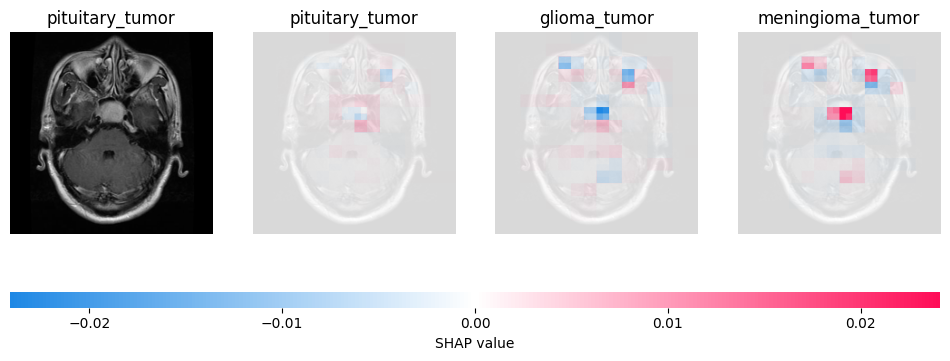

In [6]:
MEAN_VIT=[0.5000, 0.5000, 0.5000]
STD_VIT=[0.5000, 0.5000, 0.5000]

vit_model, vit_model_transforms = load_vit_model("timm.vit_base_patch16_224.augreg_in21k.PRETRAINED", NUM_CLASSES)
load_vit_model = load_model_checkpoint(vit_model, "/home/ma012/AlexServer/log/vit_best/B16_21K_case3.pth", DEVICE)

VIT_CUSTOM_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    vit_model_transforms
])

_, _, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=VIT_CUSTOM_TRANSFORMS,
    batch_size=BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

loss_fn = torch.nn.CrossEntropyLoss()

transforms_img = transforms.Lambda(nchw_to_nhwc)
inv_transform_instance = inv_transform(MEAN_VIT,STD_VIT)

def predict(img: torch.Tensor):

    img = torch.Tensor(img) #nhwc

    img = nhwc_to_nchw(img)
    img = img.to(DEVICE)
    # print("xai model:",model)
    output = load_vit_model(img)

    return output

# for images, labels, paths in test_loader:

#     images_batch = images[0:2]  
#     labels_batch = labels[0:2]  
    
#     break  

# x = images[1:2] #nchw
# # convert to nhwc for shap requirements
# x = transforms_img(x) # (1,224,224,3)

# label = labels[1:2]
# print(f"{paths[1:2]}")

test_img_path= "/home/ma012/AlexServer/Dataset/pituitary_tumor/994.jpg"
img = Image.open(test_img_path)

x = VIT_CUSTOM_TRANSFORMS(img) #3,224,224
x_expanded = x.unsqueeze(0) #1,3,224,224

x_tr = transforms_img(x_expanded) #(1,224,224,3)

# # background_image = images[0]
background_image = x
background_image = background_image.permute(1,2,0)

topk = 3
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)",background_image.shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=CLASS_NAMES)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    x_tr,
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

shap_values.data = inv_transform_instance(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[CLASS_NAMES[2]],
)

2. CNN

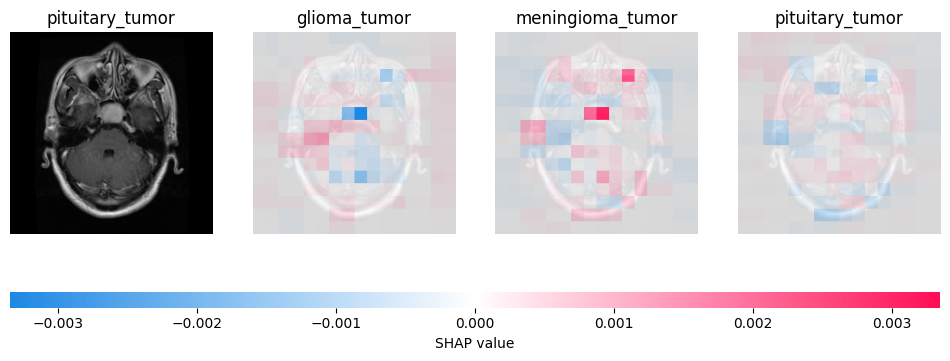

In [6]:
MEAN_CNN=[0.485, 0.456, 0.406]
STD_CNN=[0.229, 0.224, 0.225]

cnn_model, cnn_model_transforms = load_cnn_model("torchvision.MobileNet_V2_Weights.IMAGENET1K_V2", NUM_CLASSES)
cnn_model_load = load_model_checkpoint(cnn_model, "/home/ma012/AlexServer/log/cnn_best/torchvision_MobileNet_V2_Weights_IMAGENET1K_V1.pth", DEVICE)

CNN_CUSTOM_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    cnn_model_transforms
])

_, _, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=CNN_CUSTOM_TRANSFORMS,
    batch_size=BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

loss_fn = torch.nn.CrossEntropyLoss()

transforms_img = transforms.Lambda(nchw_to_nhwc)
inv_transform_instance = inv_transform(MEAN_CNN,STD_CNN)

def predict(img: torch.Tensor):

    img = torch.Tensor(img) #nhwc

    img = nhwc_to_nchw(img)
    img = img.to(DEVICE)
    # print("xai model:",model)
    output = cnn_model_load(img)

    return output

for images, labels, paths in test_loader:

    images_batch = images[0:2]  
    labels_batch = labels[0:2]  
    
    break  

# x = images[1:2] #nchw
# x = transforms_img(x) # (1,224,224,3)

# label = labels[1:2]
# print(f"{paths[1:2]}")

test_img_path= "/home/ma012/AlexServer/Dataset/pituitary_tumor/994.jpg"
img = Image.open(test_img_path)

x = CNN_CUSTOM_TRANSFORMS(img) #3,224,224
x_expanded = x.unsqueeze(0) #1,3,224,224

x_tr = transforms_img(x_expanded) #(1,224,224,3)

# # background_image = images[0]
background_image = x
background_image = background_image.permute(1,2,0)


topk = 3
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)",background_image.shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=CLASS_NAMES)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    x_tr,
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

shap_values.data = inv_transform_instance(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[CLASS_NAMES[2]],
)

# ViT SHAP

## set up

In [5]:
model,model_transforms = load_vit_model("timm.vit_base_patch16_224.augreg_in21k.PRETRAINED", NUM_CLASSES)
model_transforms

Compose(
    Resize(size=248, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
)

In [6]:
MEAN=[0.5000, 0.5000, 0.5000]
STD=[0.5000, 0.5000, 0.5000]

DEFAULT_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    model_transforms
])

transforms_img = transforms.Lambda(nchw_to_nhwc)
inv_transform_instance = inv_transform(MEAN,STD)

_, _, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=DEFAULT_TRANSFORMS,
    batch_size=BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

loss_fn = torch.nn.CrossEntropyLoss()

## Load ViT Ensemble model

In [7]:
CHECKPOINT = [
    ["/home/ma012/AlexServer/log/vit_best/B16_21K_case3.pth", "timm.vit_base_patch16_224.augreg_in21k.PRETRAINED"],
 
    ["/home/ma012/AlexServer/log/vit_best/B32_21K_case2.pth", "timm.vit_base_patch32_224.augreg_in21k.PRETRAINED"], 

    ["/home/ma012/AlexServer/log/vit_best/L16_21K_case3.pth", "timm.vit_large_patch16_224.augreg_in21k.PRETRAINED"], 
 
    ["/home/ma012/AlexServer/log/vit_best/L32_21K_case1.pth",  "timm.vit_large_patch32_224.orig_in21k.PRETRAINED" ] 
]

In [8]:
models_list = []
for cp_path, model_cfg in CHECKPOINT:
    model,model_transforms = load_vit_model(model_cfg, NUM_CLASSES)
    model = load_model_checkpoint(model, cp_path, DEVICE)
    
    models_list.append(model)

ViT original head


### Prepare Data

#### Incorrect data

In [ ]:
label = 0

# vit
incorrect_path = "/home/ma012/AlexServer/Dataset/glioma_tumor/896.jpg"

# cnn
# incorrect_path = "/home/ma012/AlexServer/Dataset/glioma_tumor/2858.jpg"

incorrect_image = Image.open(incorrect_path)

incorrect_transformed_image = DEFAULT_TRANSFORMS(incorrect_image) # chw

incorrect_transformed_image = incorrect_transformed_image.unsqueeze(0)

incorrect_transformed_image.shape

In [ ]:
x = nchw_to_nhwc(incorrect_transformed_image)
# print(x.shape) # nhwc

for images, labels, paths in test_loader:

    images_batch = images[0:2]  
    labels_batch = labels[0:2]  
    
    break  

background_image = images[0] # chw
background_image = background_image.permute(1,2,0) #hwc
# background_image = background_image.cpu().numpy()

#### Random data

In [23]:
for images, labels, paths in test_loader:

    images_batch = images[0:2]  
    labels_batch = labels[0:2]  
    
    break  

# x_idx = random.randint(0, len(images) - 1)
x_idx = 1

x = images[x_idx:x_idx+1] #nchw
# convert to nhwc for shap requirements
x = transforms_img(x) # (1,224,224,3)

label = labels[x_idx:x_idx+1]
print(f"{paths[x_idx:x_idx+1]}")

['/home/ma012/AlexServer/Dataset/pituitary_tumor/1195.jpg']


In [10]:
x.shape

torch.Size([1, 224, 224, 3])

In [11]:
background_image = images[0]
background_image = background_image.permute(1,2,0)
# background_image = background_image.cpu().numpy()

In [12]:
background_image.shape # hwc

torch.Size([224, 224, 3])

### Individual SHAP model

In [ ]:
xai_model = models_list[0]

In [ ]:
#input img: nhwc
# do: nhwc -> nchw
def predict(img: torch.Tensor):

    img = torch.Tensor(img) #nhwc

    img = nhwc_to_nchw(img)
    img = img.to(DEVICE)

    output = xai_model(img)

    return output

In [ ]:
# define a masker that is used to mask out partitions of the input image.
# bg required: (h,w,c)
masker = shap.maskers.Image("blur(128,128)",background_image.shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker, output_names=CLASS_NAMES)

# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    x, #require: nhwc
    max_evals=N_EVALS, batch_size=BATCH_SIZE_16, 
    outputs=shap.Explanation.argsort.flip[:TOPK]
)

In [ ]:
print(f"data shape : {shap_values.data.shape} type: {type(shap_values.data)} | dtype: {shap_values.data.dtype}") #nhwc
print(f"\n value shape : {shap_values.values.shape} type: {type(shap_values.values)} | dtype: {shap_values.values.dtype}") # topk,h,w,c,topk

shap_values.data = inv_transform_instance(shap_values.data).cpu().numpy()[0] 
#nhwc -> nchw -> unnorm -> hwc
print(f"inv shap data shape: {shap_values.data.shape}") # hwc
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

print(f"\n value shape : {np.array(shap_values.values).shape} type: {type(shap_values.values)}") # s,h,w,c

In [ ]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[CLASS_NAMES[label]],
)

## Ensemble XAI

In [13]:
shap_value_list = []
shap_data_list = []

for model in models_list:

    model_ensemble = model

    masker = shap.maskers.Image("blur(128,128)",background_image.shape)

    # create an explainer with model and image masker
    explainer = shap.Explainer(predict_ensemble, masker, output_names=CLASS_NAMES)

    # here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
    shap_values2 = explainer(
        x, #require: nhwc
        max_evals=N_EVALS, 
        batch_size=BATCH_SIZE_16, 
        outputs=shap.Explanation.argsort.flip[:TOPK]
    )
    
    # Idea: take the data out to the shap object
    shap_value_list.append(shap_values2[0])
    shap_data_list.append(shap_values2.data)

PartitionExplainer explainer: 2it [00:24, 24.19s/it]               
PartitionExplainer explainer: 2it [00:12, 12.01s/it]               
PartitionExplainer explainer: 2it [00:58, 58.66s/it]               
PartitionExplainer explainer: 2it [00:22, 22.11s/it]               


In [14]:
type(shap_values2.data)

torch.Tensor

In [15]:
print(f"shape of shap_values2.values:{shap_values2[0].values.shape}")

shape of shap_values2.values:(224, 224, 3, 3)


In [16]:
shap_value_ensemble = np.zeros_like(shap_value_list[0].values) #(224, 224, 3, 3)

for shap_value in shap_value_list:
    shap_value_ensemble +=shap_value.values

shap_value_ensemble = shap_value_ensemble / len(models_list) # (224,224,3,3)
print(f"shape:{shap_value_ensemble.shape}")

# axa =  [val for val in np.moveaxis(shap_value_ensemble,-1,0)]
# axa[2].shape

shape:(224, 224, 3, 3)


In [17]:
shap_values2.values[0].shape

(224, 224, 3, 3)

In [18]:
shap_value_ensemble = np.zeros_like(shap_value_list[0].values) #(224, 224, 3, 3)

for shap_value in shap_value_list:
    shap_value_ensemble +=shap_value.values

shap_value_ensemble = shap_value_ensemble / len(models_list) # (224,224,3,3)

# shap_value_ensemble from (224,224,3,3) to list[0]
# list[0].shape -> 224,224,3

# before: 
# shap_values2.values (1, 224, 224, 3, 3)
# shap_values2.values[0].shape (224,224,3,3)

# update to the shap value object
shap_values2.values = [val for val in np.moveaxis(shap_value_ensemble,-1,0)] 
# shap_values2.values[0].shape (224,224,3)
# shap_values2.values (3,224,224,3)

In [19]:
A = np.array(shap_values2.values)
A.shape

(3, 224, 224, 3)

In [20]:
shap_data_ensemble = torch.zeros_like(shap_data_list[0])

for shap_data in shap_data_list:

    shap_data_ensemble += shap_data

shap_data_ensemble = shap_data_ensemble / len(models_list) # torch.Size
# print(f"shape:{shap_data_ensemble.shape}")

# print(inv_transform_instance(shap_data_ensemble).cpu().numpy().shape)
# print(inv_transform_instance(shap_data_ensemble).cpu().numpy()[0].shape)
# update to the shap data object
shap_values2.data = inv_transform_instance(shap_data_ensemble).cpu().numpy()[0]

In [21]:
print(f"{len(shap_values2.data )} | {len(shap_values2.values)}")

224 | 3


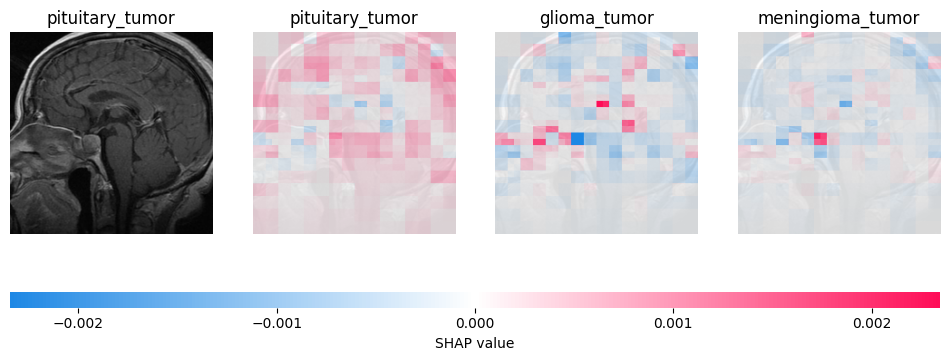

In [22]:
shap.image_plot(
    shap_values=shap_values2.values,
    pixel_values=shap_values2.data,
    labels=shap_values2.output_names,
    true_labels=[CLASS_NAMES[label]],
)

In [ ]:
print(x_idx)

In [ ]:
# Get the dataset inside the test_loader
test_dataset = test_loader.dataset

# Access index 1
image, label, path = test_dataset[1]

# Print the path
print("Image path at index 1:", path)


In [ ]:
saving_shap_values = shap_values2.values
shap_values_np = np.array(saving_shap_values)
shap_values_np.shape

In [ ]:
np.save("/home/ma012/AlexServer/log/XAI/correct/ViT_ensemble_pt1195.npy", shap_values_np)

## Plot histogram

In [ ]:
# Define color labels
colors = ['red', 'green', 'blue']

# Create a single row of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # (rows, columns)

# Loop over RGB channels
for i, color in enumerate(colors):
    # Extract the specific channel for all images and flatten
    pixels = shap_values_np[:, :, :, i].flatten()
    
    # Plot histogram in the corresponding subplot
    axes[i].hist(pixels, bins=256, color=color, alpha=0.7)
    axes[i].set_title(f'{color.upper()} Channel Histogram')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim([np.min(pixels), np.max(pixels)])  # Auto-scale x-axis

# Adjust layout for better spacing
plt.tight_layout()

# Show the row of histograms
plt.show()


# **Develop stage**

## **Multiple Images with SHAP**

**Problem**
- Multiple image leads to expand the dimension of shape_values
- Have to deal with it before combine all shape values together

**Parameter details:**
-- In single image --
1. shap_values have shape (1,224,224,3) #nhwc
    - shap_values2[0].shape (224,224,3,3)
    - type(shap_values2.values) numpy.ndarray

-- In multiple images --
1. shap_values have shape 
    - print(shap_values3.values.shape) #(3,224,224,3,3) # ndarry
    - print(shap_values3.data.shape) #(3,224,224,3,3) #Tensor
    - type(shap_values2.values) numpy.ndarray

and It has three shap values:
    - shap_values.values[i] (224,224,3,3)
    - shap_values.data[i] # (224,224,3)

- len(shap_values2)

**Way**
1. Append each shap_values.values[i] in to the list {}
    - list type:
        i : shap_values.values[i]
    - data list:
        i : shap_values.data[i]
2. Combine and take average
3. For each shap_values[i].values = list[i]

In [8]:
for images, labels, paths in test_loader:

    images_batch = images[0:2]  
    labels_batch = labels[0:2]  
    
    break  

In [9]:
# X = images[1:4]
X = images[x_idx:x_idx+3]

correct_labels = labels[x_idx:x_idx+3]

print(f"ori shape: {X.shape}") #nchw
print(f"label:{correct_labels}")
print(f"label:{paths[x_idx:x_idx+3]}")


X_transformed = transforms_img(X)
print(f"\n reshape X:{X_transformed.shape}") #nhwc

ori shape: torch.Size([3, 3, 224, 224])
label:tensor([0, 0, 0])
label:['/home/ma012/AlexServer/Dataset/glioma_tumor/2479.jpg', '/home/ma012/AlexServer/Dataset/glioma_tumor/2298.jpg', '/home/ma012/AlexServer/Dataset/glioma_tumor/2402.jpg']

 reshape X:torch.Size([3, 224, 224, 3])


### Load ViT SHAP

In [12]:
shap_value_dict_list = []
shap_data_dict_list = [] 

for model in models_list:
    model_ensemble = model

    masker = shap.maskers.Image("blur(128,128)",X_transformed[0].shape)

    # create an explainer with model and image masker
    explainer = shap.Explainer(predict_ensemble, masker, output_names=CLASS_NAMES)

    # here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
    shap_values3 = explainer(
        X_transformed, #require: nhwc
        max_evals=N_EVALS, 
        batch_size=BATCH_SIZE_16, 
        outputs=shap.Explanation.argsort.flip[:TOPK]
    )
    
    for idx in range(len(shap_values3)): 
        if len(shap_value_dict_list) > idx:
            shap_value_dict_list[idx] += shap_values3.values[idx]
        else:
            shap_value_dict_list.append(shap_values3.values[idx])

        if len(shap_data_dict_list) > idx:
            shap_data_dict_list[idx] += shap_values3.data[idx]
        else:
            shap_data_dict_list.append(shap_values3.data[idx])

PartitionExplainer explainer: 4it [01:10, 23.46s/it]                       
PartitionExplainer explainer: 4it [00:36, 12.11s/it]                       
PartitionExplainer explainer: 4it [02:55, 58.55s/it]                       
PartitionExplainer explainer: 4it [01:05, 21.97s/it]                       


In [13]:
n_img_ensemble_shap_values = []
n_img_ensemble_shap_data = []

for i in range(len(shap_value_dict_list)):
    n_img_ensemble_shap_values.append(shap_value_dict_list[i] / len(models_list)) #list
    n_img_ensemble_shap_data.append(shap_data_dict_list[i] / len(models_list))

n_img_ensemble_shap_values_array = np.array(n_img_ensemble_shap_values)
# print(ensemble_shap_array.shape) #(3, 224, 224, 3, 3)
n_img_ensemble_shap_data_tensor = torch.stack(n_img_ensemble_shap_data)
# print(n_img_ensemble_shap_data_tensor.shape) #(3, 224, 224, 3, 3)


In [14]:
shap_values3.values = [val for val in np.moveaxis(n_img_ensemble_shap_values_array,-1,0)] 
shap_values3.data = inv_transform_instance(n_img_ensemble_shap_data_tensor).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4058824].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4607843].


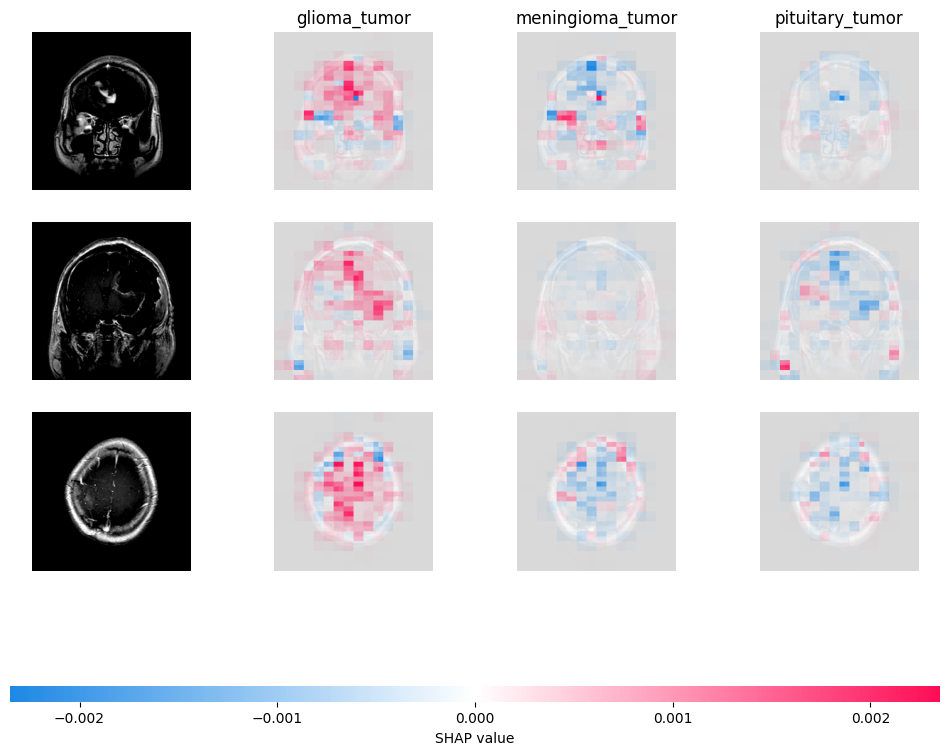

In [15]:
shap.image_plot(
    shap_values=shap_values3.values,
    pixel_values=shap_values3.data,
    labels=shap_values3.output_names,
    # true_labels=[CLASS_NAMES[labels]],
)

In [16]:
for i in range(len(correct_labels)):
    print(CLASS_NAMES[correct_labels[i]])

glioma_tumor
glioma_tumor
glioma_tumor


# **CNN SHAP**

In [31]:
_,cnn_model_transforms = load_cnn_model(DEVICE,"torchvision.VGG16_Weights.IMAGENET1K_V1", NUM_CLASSES)
cnn_model_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [32]:
MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]

DEFAULT_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    cnn_model_transforms
])

transforms_img = transforms.Lambda(nchw_to_nhwc)
inv_transform_instance = inv_transform(MEAN,STD)

_, _, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=DEFAULT_TRANSFORMS,
    batch_size=BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

loss_fn = torch.nn.CrossEntropyLoss()

In [33]:
for images, labels, paths in test_loader:

    images_batch = images[0:2]  
    labels_batch = labels[0:2]  
    
    break  

# x_idx = random.randint(0, len(images) - 1)
x_idx = 1

x = images[x_idx:x_idx+1] #nchw
# convert to nhwc for shap requirements
x = transforms_img(x) # (1,224,224,3)

label = labels[x_idx:x_idx+1]
print(f"{paths[x_idx:x_idx+1]}")

background_image = images[0]
background_image = background_image.permute(1,2,0)
# background_image = background_image.cpu().numpy()

['/home/ma012/AlexServer/Dataset/pituitary_tumor/1195.jpg']


In [35]:
cnn_models_list = []

for cp_path, model_cfg in CHECKPOINT_CNN:
    # print(model_cfg)
    model_cnn,model_transforms_cnn = load_cnn_model(DEVICE,model_cfg, NUM_CLASSES)
    model_cnn = load_model_checkpoint(model_cnn, cp_path, DEVICE)
    
    cnn_models_list.append(model_cnn)

In [36]:
print(np.array(cnn_models_list).shape)

(4,)


In [37]:
cnn_shap_value_list = []
cnn_shap_data_list = []

for model in cnn_models_list:

    model_ensemble = model

    # print(model)

    masker = shap.maskers.Image("blur(128,128)",background_image.shape)

    explainer = shap.Explainer(predict_ensemble, masker, output_names=CLASS_NAMES)

    cnn_shap_values = explainer(
        x, #require: nhwc
        max_evals=N_EVALS, 
        batch_size=BATCH_SIZE_16, 
        outputs=shap.Explanation.argsort.flip[:TOPK]
    )
    
    cnn_shap_value_list.append(cnn_shap_values[0])
    cnn_shap_data_list.append(cnn_shap_values.data)

print(f"data list shape:{np.array(cnn_shap_data_list).shape}")
cnn_shap_value_ensemble = np.zeros_like(cnn_shap_value_list[0].values) #(224, 224, 3, 3)

for shap_value in cnn_shap_value_list:
    cnn_shap_value_ensemble += shap_value.values

cnn_shap_value_ensemble = cnn_shap_value_ensemble / len(cnn_models_list) # (224,224,3,3)
cnn_shap_values.values = [val for val in np.moveaxis(cnn_shap_value_ensemble,-1,0)] 

cnn_shap_data_ensemble = torch.zeros_like(cnn_shap_data_list[0])

for shap_data in cnn_shap_data_list:

    cnn_shap_data_ensemble += shap_data

cnn_shap_data_ensemble = cnn_shap_data_ensemble / len(cnn_models_list) # torch.Size

cnn_shap_values.data = inv_transform_instance(cnn_shap_data_ensemble).cpu().numpy()[0]

PartitionExplainer explainer: 2it [03:24, 204.90s/it]              
PartitionExplainer explainer: 2it [01:36, 96.37s/it]               
PartitionExplainer explainer: 2it [01:36, 96.70s/it]               
PartitionExplainer explainer: 2it [02:03, 123.08s/it]              

data list shape:(4, 1, 224, 224, 3)


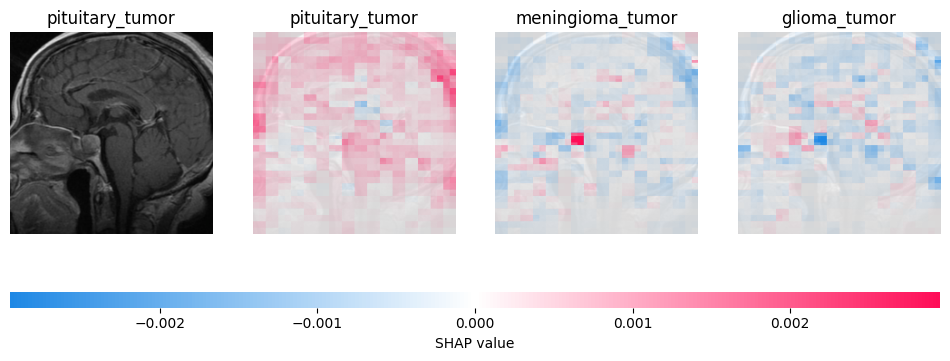

In [38]:
shap.image_plot(
    shap_values=cnn_shap_values.values,
    pixel_values=cnn_shap_values.data,
    labels=cnn_shap_values.output_names,
    true_labels=[CLASS_NAMES[label]],
)

### Run SHAP - Multiple Images

In [ ]:
# X = images[1:4]

x_idx = random.randint(0, 11)
X_cnn = images[x_idx:x_idx+3]

cnn_correct_labels = labels[x_idx:x_idx+3]

print(f"ori shape: {X_cnn.shape}") #nchw
print(f"label:{cnn_correct_labels}")
print(f"paths:{paths[x_idx:x_idx+3]}")


X_cnn_transformed = transforms_img(X_cnn)
print(f"\n reshape X:{X_cnn_transformed.shape}") #nhwc

In [23]:
CNN_shap_value_dict_list = []
CNN_shap_data_dict_list = [] 

for model in cnn_models_list:
    model_ensemble = model

    masker = shap.maskers.Image("blur(128,128)",X_cnn_transformed[0].shape)

    # create an explainer with model and image masker
    explainer = shap.Explainer(predict_ensemble, masker, output_names=CLASS_NAMES)

    # here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
    shap_values4 = explainer(
        X_cnn_transformed, #require: nhwc
        max_evals=N_EVALS, 
        batch_size=BATCH_SIZE_16, 
        outputs=shap.Explanation.argsort.flip[:TOPK]
    )
    
    for idx in range(len(shap_values4)): 
        if len(CNN_shap_value_dict_list) > idx:
            CNN_shap_value_dict_list[idx] += shap_values4.values[idx]
        else:
            CNN_shap_value_dict_list.append(shap_values4.values[idx])

        if len(CNN_shap_data_dict_list) > idx:
            CNN_shap_data_dict_list[idx] += shap_values4.data[idx]
        else:
            CNN_shap_data_dict_list.append(shap_values4.data[idx])
            
cnn_n_img_ensemble_shap_values = []
cnn_n_img_ensemble_shap_data = []

for i in range(len(CNN_shap_value_dict_list)):
    cnn_n_img_ensemble_shap_values.append(CNN_shap_value_dict_list[i] / len(cnn_models_list)) #list
    cnn_n_img_ensemble_shap_data.append(CNN_shap_data_dict_list[i] / len(cnn_models_list))

cnn_n_img_ensemble_shap_values_array = np.array(cnn_n_img_ensemble_shap_values)
# print(ensemble_shap_array.shape) #(3, 224, 224, 3, 3)
cnn_n_img_ensemble_shap_data_tensor = torch.stack(cnn_n_img_ensemble_shap_data)
# print(n_img_ensemble_shap_data_tensor.shape) #(3, 224, 224, 3, 3)

shap_values4.values = [val for val in np.moveaxis(cnn_n_img_ensemble_shap_values_array,-1,0)] 
shap_values4.data = inv_transform_instance(cnn_n_img_ensemble_shap_data_tensor).cpu().numpy()

PartitionExplainer explainer: 4it [00:59, 19.82s/it]                       
PartitionExplainer explainer: 4it [00:28, 14.30s/it]               
PartitionExplainer explainer: 4it [00:29, 14.52s/it]               
PartitionExplainer explainer: 4it [00:36, 12.18s/it]                       


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4693137..1.5234119].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46147063..1.4998822].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4771569..1.5626273].


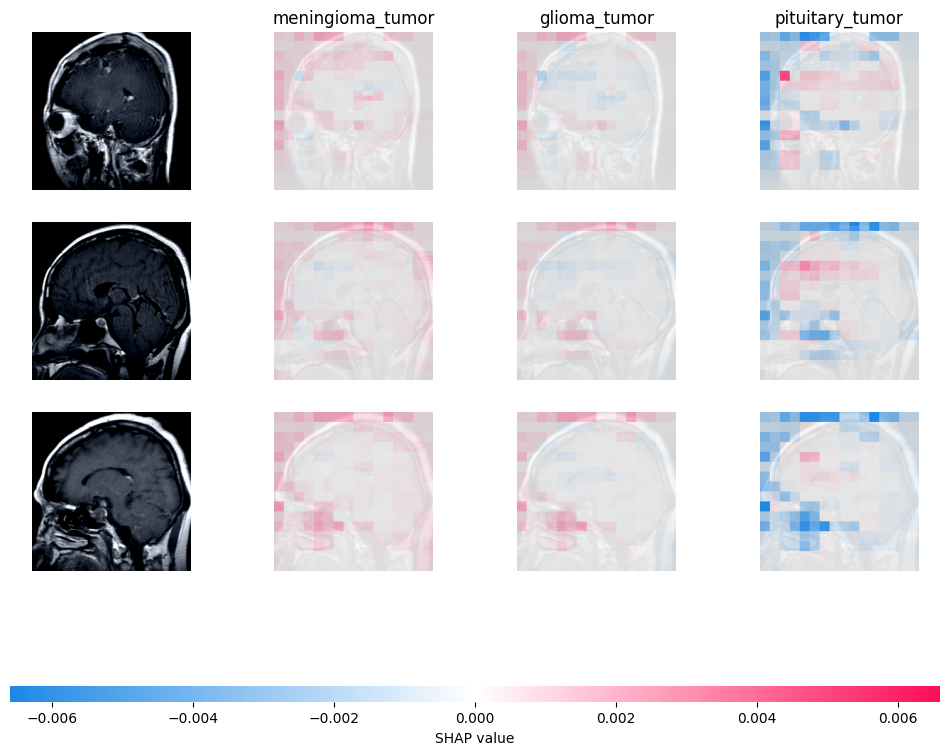

In [24]:
shap.image_plot(
    shap_values=shap_values4.values,
    pixel_values=shap_values4.data,
    labels=shap_values4.output_names,
    # true_labels=[CLASS_NAMES[labels]],
)

In [25]:
for i in range(len(cnn_correct_labels)):
    print(CLASS_NAMES[cnn_correct_labels[i]])

glioma_tumor
pituitary_tumor
pituitary_tumor


In [26]:
shap_values4.output_names

[np.str_('meningioma_tumor'),
 np.str_('glioma_tumor'),
 np.str_('pituitary_tumor')]

# **LIME**

## ViT configuration

In [6]:

MEAN_VIT=[0.5000, 0.5000, 0.5000]
STD_VIT=[0.5000, 0.5000, 0.5000]

vit_model, vit_model_transforms = load_vit_model("timm.vit_base_patch16_224.augreg_in21k.PRETRAINED", NUM_CLASSES)
load_vit_model = load_model_checkpoint(vit_model, "/home/ma012/AlexServer/log/vit_best/B16_21K_case3.pth", DEVICE)

VIT_CUSTOM_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    vit_model_transforms
])

_, _, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=VIT_CUSTOM_TRANSFORMS,
    batch_size=BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

loss_fn = torch.nn.CrossEntropyLoss()

## CNN configuration

In [7]:
MEAN_CNN=[0.485, 0.456, 0.406]
STD_CNN=[0.229, 0.224, 0.225]

cnn_model, cnn_model_transforms = load_cnn_model("torchvision.MobileNet_V2_Weights.IMAGENET1K_V2", NUM_CLASSES)
cnn_model_load = load_model_checkpoint(cnn_model, "/home/ma012/AlexServer/log/cnn_best/torchvision_MobileNet_V2_Weights_IMAGENET1K_V1.pth", DEVICE)

CNN_CUSTOM_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    cnn_model_transforms
])

_, _, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=CNN_CUSTOM_TRANSFORMS,
    batch_size=BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

loss_fn = torch.nn.CrossEntropyLoss()

## LIME - General Configuration

In [8]:
# input transform for LIME
def get_pil_transform(type='vit'): 

    CROP_SIZE = 224

    if(type=='cnn'):
        RESIZE_SIZE = (256,256)
        print("cnn")
    else:
        RESIZE_SIZE = (248,248)

    transf = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(RESIZE_SIZE, interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(CROP_SIZE)
    ])    

    return transf

# add convert to tensor for model
def get_preprocess_transform(type='vit'): 

    if(type == 'cnn'):
        mean = MEAN_CNN
        std = STD_CNN
        print("cnn")
    else:
        mean = MEAN_VIT
        std = STD_VIT

    normalize = transforms.Normalize(mean,std)
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

In [8]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

models_list = []
for cp_path, model_cfg in ViT_CHECKPOINT:
    model,model_transforms = load_vit_model(model_cfg, NUM_CLASSES)
    model = load_model_checkpoint(model, cp_path, DEVICE)
    
    models_list.append(model)

ViT original head


In [10]:
pill_transf = get_pil_transform('cnn')
preprocess_transform = get_preprocess_transform('cnn')

models_list = []
for cp_path, model_cfg in CNN_CHECKPOINT:
    model,model_transforms = load_cnn_model(DEVICE,model_cfg, NUM_CLASSES)
    model = load_model_checkpoint(model, cp_path, DEVICE)
    
    models_list.append(model)

cnn
cnn


### get image 

In [9]:
# Both of ViT & CNN Incorrect: "/home/ma012/AlexServer/Dataset/meningioma_tumor/33.jpg"
test_img_path="/home/ma012/AlexServer/Dataset/pituitary_tumor/994.jpg"
img = Image.open(test_img_path)

# image_unnormalize = inv_transform_instance(images[1])
# img_input = np.array(image_unnormalize) #hwc

### Single model LIME

1. ViT

100%|██████████| 1000/1000 [00:02<00:00, 390.91it/s]


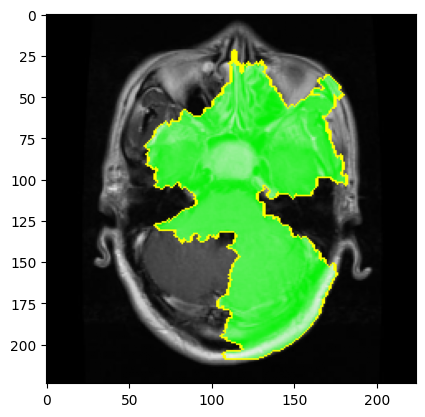

In [10]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def lime_predict(images):
 
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    batch = batch.to(DEVICE)

    logits = load_vit_model(batch)
    probs = F.softmax(logits,dim = 1)

    return probs.detach().cpu().numpy()

#input image: hwc

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         lime_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # size of the neighborhood to learn the linear model
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)

plt.imshow(img_boundry)

2. CNN

cnn
cnn


100%|██████████| 1000/1000 [00:01<00:00, 827.79it/s]


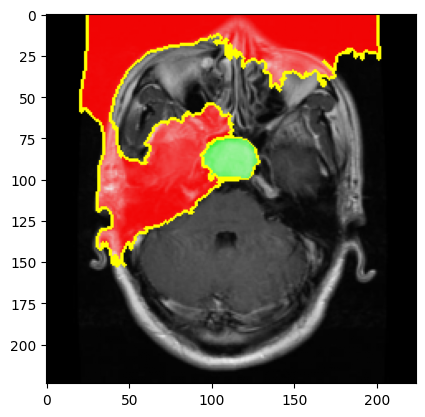

In [11]:
pill_transf = get_pil_transform('cnn')
preprocess_transform = get_preprocess_transform('cnn')

def lime_predict(images):
 
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    batch = batch.to(DEVICE)

    logits = cnn_model_load(batch)
    probs = F.softmax(logits,dim = 1)

    return probs.detach().cpu().numpy()

#input image: hwc

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         lime_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # size of the neighborhood to learn the linear model
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)

plt.imshow(img_boundry1)


## **Ensemble Model LIME**

### ViT

In [12]:
def lime_predict_ensemble(images):
 
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    batch = batch.to(DEVICE)

    probs_ensemble = None

    for model in models_list:
        logits = model(batch)
        probs = torch.softmax(logits,dim = 1)
        if probs_ensemble is None:
            probs_ensemble = probs.clone()
        else:
            probs_ensemble += probs

    probs_ensemble = probs_ensemble / len(models_list)
    
    return probs_ensemble.detach().cpu().numpy()

In [11]:
explainer_ensemble = lime_image.LimeImageExplainer()

explanation_ensemble = explainer_ensemble.explain_instance(np.array(pill_transf(img)), 
                                         lime_predict_ensemble, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=1000) # size of the neighborhood to learn the linear model

100%|██████████| 1000/1000 [00:10<00:00, 98.24it/s]


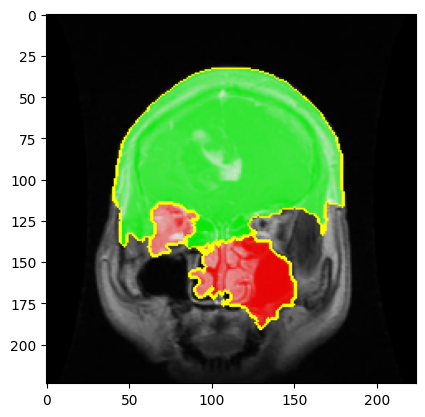

In [12]:
# num_features = number of superpixels(image regions), the most n important regions (according to LIME) will be shown in mask
# hide_rests = all parts of the image that are not in the top num_features will be hidden
# temp/255.0 -> scales the image values from [0,255] (standard pixel range) to [0.0,1.0] as expected by mark_boudaries
# mask: that indicates which superpixels are considered important
temp2, mask2 = explanation_ensemble.get_image_and_mask(explanation_ensemble.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry2 = mark_boundaries(temp2/255.0, mask2)

plt.imshow(img_boundry2)

### CNN

100%|██████████| 1000/1000 [00:03<00:00, 303.50it/s]


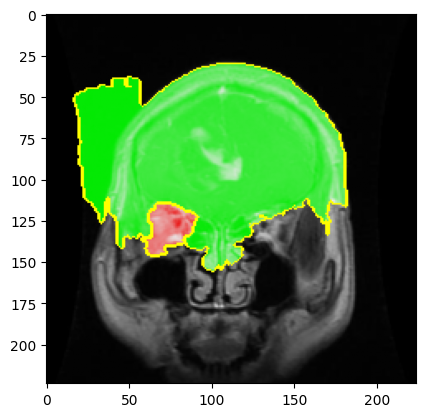

In [13]:
cnn_explainer_ensemble = lime_image.LimeImageExplainer()

cnn_explanation_ensemble = cnn_explainer_ensemble.explain_instance(np.array(pill_transf(img)), 
                                         lime_predict_ensemble, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=1000) # size of the neighborhood to learn the linear model

temp_cnn, mask_cnn = cnn_explanation_ensemble.get_image_and_mask(cnn_explanation_ensemble.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry_cnn = mark_boundaries(temp_cnn/255.0, mask_cnn)

plt.imshow(img_boundry_cnn)

/home/ma012/AlexServer/Dataset/glioma_tumor/2479.jpg